#### Contents

0. [Load data and preprocess](#Load-data-and-preprocess)
1. [Initialize VRAE object](#Initialize-VRAE-object)
2. [Fit the model onto dataset](#Fit-the-model-onto-dataset)
3. [Transform the input timeseries to encoded latent vectors](#Transform-the-input-timeseries-to-encoded-latent-vectors)
4. [Save the model to be fetched later](#Save-the-model-to-be-fetched-later)

### Import required modules

In [1]:
from model.vrae import VRAE

from model.utils import *
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
from tqdm.notebook import trange
import tqdm

import pickle

from sklearn.preprocessing import MinMaxScaler


### Input parameters

In [2]:
dload = './saved_model' #download directory

### utils.load_data

In [3]:
def load_gen_data(file_name, cols_to_remove = None):
    """
    folder: folder where data is located
    """
    
    # define path(must be in pkl file)
    data_loc = f'./data/netis/{file_name}.pkl'    
    
    # get data
    with open(data_loc, 'rb') as f:
        df = pickle.load(f)
    
    # if needed remove columns that is not necessary
    if cols_to_remove != None:
        df = df_total.drop(cols_to_remove, axis=1)
    
    df = df.dropna()
    
    # TRAIN TEST SPLIT
    # TRAIN
    TRAIN_DF = df.query('Time < 20211103184400 or Time > 20211106084400 and label==0')
    
    # TEST(GET ONLY 정상)
    TEST_DF = df.query('Time >= 20211103184400 and Time <= 20211106084400 and label==0')

    TOTAL_DF = df.to_numpy()
    
    # REMOVE TIME & LABEL
    TRAIN_DF = TRAIN_DF.iloc[:,1:-1]
    TEST_DF = TEST_DF.iloc[:,1:-1]
    
    scaler = MinMaxScaler()
    
    TRAIN_SCALED_DF = scaler.fit(TRAIN_DF).transform(TRAIN_DF)
    TEST_SCALED_DF = scaler.transform(TEST_DF)
    
    return TOTAL_DF, TRAIN_SCALED_DF, TEST_SCALED_DF

### Hyper parameters

### Load data and preprocess
- `file_name` : pkl file_name
- `cols_to_remove` : generation 수행하지 않을 column 제거

In [4]:
# params
file_name = 'netis'

# load data
TOTAL_DF, TRAIN_DF, TEST_DF = load_gen_data(file_name)

# shape
print(TOTAL_DF.shape)
print(TRAIN_DF.shape)
print(TEST_DF.shape)

(26002, 94)
(22363, 92)
(3627, 92)


In [5]:
TRAIN_DF

array([[3.66328864e-04, 2.52639355e-05, 2.90615333e-05, ...,
        3.42446043e-01, 4.98597475e-01, 1.65289256e-01],
       [2.66795942e-04, 3.25753827e-05, 3.13032504e-05, ...,
        3.51079137e-01, 4.97896213e-01, 1.65289256e-01],
       [2.01613776e-04, 1.37864421e-05, 3.04728091e-05, ...,
        3.51079137e-01, 4.97896213e-01, 1.23966942e-01],
       ...,
       [2.66813941e-03, 9.48559406e-04, 3.24553957e-06, ...,
        6.04316547e-01, 9.89481066e-01, 2.89256198e-01],
       [1.45200665e-03, 2.26151271e-03, 3.08280452e-06, ...,
        6.04316547e-01, 9.88779804e-01, 3.05785124e-01],
       [8.30917887e-03, 8.96945321e-04, 7.79900694e-06, ...,
        6.04316547e-01, 9.88779804e-01, 2.97520661e-01]])

In [6]:
TEST_DF

array([[4.02355635e-03, 6.62881732e-05, 1.69243372e-05, ...,
        6.79136691e-01, 3.52033661e-01, 2.14876033e-01],
       [4.07135202e-03, 1.18662977e-04, 6.92800865e-06, ...,
        6.79136691e-01, 3.52734923e-01, 2.14876033e-01],
       [4.02378633e-03, 2.82489361e-04, 2.07942738e-05, ...,
        6.79136691e-01, 3.52734923e-01, 2.14876033e-01],
       ...,
       [3.98419630e-03, 7.85747554e-05, 1.75819403e-05, ...,
        5.98561151e-01, 4.25666199e-01, 2.56198347e-01],
       [3.98799304e-03, 4.90275879e-05, 3.81572787e-06, ...,
        6.00000000e-01, 4.24964937e-01, 2.56198347e-01],
       [3.93781591e-03, 3.97621553e-05, 8.13602856e-06, ...,
        6.04316547e-01, 4.24964937e-01, 2.47933884e-01]])

In [7]:
class GenerationDataset(Dataset):
    def __init__(self, data, window):
        self.data = torch.Tensor(data)
        self.window = window
 
    def __len__(self):
        return len(self.data) // self.window # -1
    
    def __getitem__(self, index):
#         x = self.data[index*self.window:index*(self.window+1)]
        x = self.data[index*self.window:(index+1)*(self.window)]
        return x

In [8]:
window = 100

In [9]:
train_dataset = GenerationDataset(TRAIN_DF, window)
train_dataset

In [10]:
test_dataset = GenerationDataset(TEST_DF, window)
test_dataset

In [11]:
train_dataset[0].shape

torch.Size([100, 92])

**Fetch `sequence_length` from dataset**

In [12]:
sequence_length = train_dataset[0].shape[0]
sequence_length

100

**Fetch `number_of_features` from dataset**

This config corresponds to number of input features

In [13]:
number_of_features = train_dataset[0].shape[1]
number_of_features

92

### Parameters

In [14]:
n_epochs = 1000
hidden_size = 90
hidden_layer_depth = 1
latent_length = 20
batch_size = 1
learning_rate = 0.0005
dropout_rate = 0.2
optimizer = 'Adam' # options: ADAM, SGD
cuda = True # options: True, False
print_every=30
clip = True # options: True, False
max_grad_norm=5
loss = 'MSELoss' # options: SmoothL1Loss, MSELoss
block = 'LSTM' # options: LSTM, GRU

### Initialize VRAE object

VRAE inherits from `sklearn.base.BaseEstimator` and overrides `fit`, `transform` and `fit_transform` functions, similar to sklearn modules

In [15]:
vrae = VRAE(sequence_length=sequence_length,
            number_of_features = number_of_features,
            hidden_size = hidden_size, 
            hidden_layer_depth = hidden_layer_depth,
            latent_length = latent_length,
            batch_size = batch_size,
            learning_rate = learning_rate,
            n_epochs = n_epochs,
            dropout_rate = dropout_rate,
            optimizer = optimizer, 
            cuda = cuda,
            print_every=print_every, 
            clip=clip, 
            max_grad_norm=max_grad_norm,
            loss = loss,
            block = block,
            dload = dload)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


### Fit the model onto dataset

In [16]:
loss_arr = vrae.fit(train_dataset)

#If the model has to be saved, with the learnt parameters use:
# vrae.fit(dataset, save = True)

Epoch: 0
Batch 30, loss = 17.4664, recon_loss = 17.4569, kl_loss = 0.0095
Batch 60, loss = 1.4186, recon_loss = 1.2566, kl_loss = 0.1620
Batch 90, loss = 1.2616, recon_loss = 1.0894, kl_loss = 0.1722
Batch 120, loss = 0.8010, recon_loss = 0.7030, kl_loss = 0.0980
Batch 150, loss = 120.3023, recon_loss = 120.1448, kl_loss = 0.1576
Batch 180, loss = 34.2725, recon_loss = 34.0186, kl_loss = 0.2539
Batch 210, loss = 129.4178, recon_loss = 129.2956, kl_loss = 0.1222
Average loss: 38.3557
Epoch: 1
Batch 30, loss = 24.7929, recon_loss = 24.7298, kl_loss = 0.0631
Batch 60, loss = 1.1548, recon_loss = 1.0877, kl_loss = 0.0672
Batch 90, loss = 1.3305, recon_loss = 1.2788, kl_loss = 0.0517
Batch 120, loss = 0.7125, recon_loss = 0.5974, kl_loss = 0.1151
Batch 150, loss = 131.1237, recon_loss = 130.8533, kl_loss = 0.2704
Batch 180, loss = 63.8103, recon_loss = 63.6072, kl_loss = 0.2032
Batch 210, loss = 76.1383, recon_loss = 76.0502, kl_loss = 0.0881
Average loss: 45.7909
Epoch: 2
Batch 30, loss = 

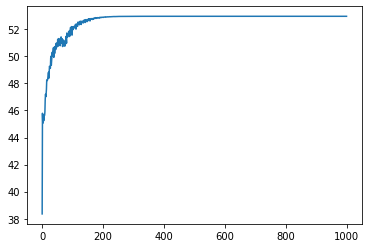

In [17]:
import matplotlib.pyplot as plt

plt.plot(loss_arr)

### Save the model to be fetched later

In [18]:
vrae.save('vrae.pth')

# To load a presaved model, execute:
# vrae.load('vrae.pth')

In [19]:
vrae.is_fitted

True

### Transform the input timeseries to encoded latent vectors

In [20]:
z_run = vrae.transform(test_dataset)
z_run

array([[ 1.79847702e-05,  1.36362389e-04, -2.83252099e-04,
         1.25985360e-04,  1.67107210e-04, -1.02168415e-04,
        -2.88588461e-04, -3.07596754e-04,  1.06943771e-05,
        -1.96422450e-04, -3.72366048e-05,  8.67777038e-04,
        -2.03973614e-04,  4.93438449e-04,  7.25621358e-05,
         5.10640442e-04, -1.24490587e-04, -3.33525706e-04,
        -3.49851325e-05, -1.92600768e-04],
       [-2.63493275e-05,  3.90368514e-05, -2.32314575e-04,
         1.78438146e-04,  3.18352133e-04, -2.00892333e-04,
        -3.71992588e-04, -1.87492464e-04,  5.32548875e-05,
        -2.48712488e-04,  6.43865205e-05,  9.93547495e-04,
        -7.34142959e-05,  5.78490086e-04,  1.39834825e-04,
         3.70921567e-04, -1.90875260e-04, -4.01899219e-04,
        -1.79168768e-04, -3.02824192e-04],
       [ 7.39648240e-05,  6.87907450e-05, -2.14183703e-04,
         1.29580731e-04,  1.37869269e-04, -1.03700440e-04,
        -2.55871098e-04, -2.57416163e-04, -3.02917324e-05,
        -1.33020338e-04, -2.0

In [21]:
z_run.shape

(36, 20)

In [22]:
def concat_reconstruction():
    pass

### Reconstruct

In [23]:
TRAIN_DF.shape

(22363, 92)

In [24]:
# train reconstruct
train_reconstruction = vrae.reconstruct(train_dataset)
print(train_reconstruction.shape)
train_reconstruction

(100, 223, 92)


array([[[ 8.0083683e-03,  5.4104272e-03, -4.7870685e-04, ...,
          4.5372239e-01,  5.9949720e-01,  2.0444836e-01],
        [ 8.0082528e-03,  5.4103662e-03, -4.7875577e-04, ...,
          4.5372221e-01,  5.9949714e-01,  2.0444877e-01],
        [ 8.0082724e-03,  5.4103765e-03, -4.7874768e-04, ...,
          4.5372224e-01,  5.9949714e-01,  2.0444871e-01],
        ...,
        [ 8.0084149e-03,  5.4104514e-03, -4.7868714e-04, ...,
          4.5372248e-01,  5.9949720e-01,  2.0444818e-01],
        [ 8.0084577e-03,  5.4104743e-03, -4.7866884e-04, ...,
          4.5372257e-01,  5.9949720e-01,  2.0444801e-01],
        [ 8.0084167e-03,  5.4104528e-03, -4.7868618e-04, ...,
          4.5372248e-01,  5.9949720e-01,  2.0444818e-01]],

       [[ 8.0478741e-03,  6.1386432e-03, -8.1713905e-04, ...,
          4.5264015e-01,  5.9815502e-01,  2.0751545e-01],
        [ 8.0478694e-03,  6.1386344e-03, -8.1713276e-04, ...,
          4.5264015e-01,  5.9815502e-01,  2.0751543e-01],
        [ 8.0478713e-03, 

In [25]:
TEST_DF.shape

(3627, 92)

In [26]:
# test reconstruct
test_reconstruction = vrae.reconstruct(test_dataset)
print(test_reconstruction.shape)
test_reconstruction

(100, 36, 92)


array([[[ 8.0083888e-03,  5.4104384e-03, -4.7869800e-04, ...,
          4.5372245e-01,  5.9949720e-01,  2.0444828e-01],
        [ 8.0083804e-03,  5.4104337e-03, -4.7870155e-04, ...,
          4.5372242e-01,  5.9949720e-01,  2.0444831e-01],
        [ 8.0083767e-03,  5.4104314e-03, -4.7870338e-04, ...,
          4.5372242e-01,  5.9949720e-01,  2.0444833e-01],
        ...,
        [ 8.0083879e-03,  5.4104375e-03, -4.7869841e-04, ...,
          4.5372242e-01,  5.9949720e-01,  2.0444828e-01],
        [ 8.0083981e-03,  5.4104431e-03, -4.7869416e-04, ...,
          4.5372245e-01,  5.9949720e-01,  2.0444824e-01],
        [ 8.0083907e-03,  5.4104393e-03, -4.7869724e-04, ...,
          4.5372245e-01,  5.9949720e-01,  2.0444827e-01]],

       [[ 8.0478741e-03,  6.1386451e-03, -8.1714062e-04, ...,
          4.5264015e-01,  5.9815502e-01,  2.0751546e-01],
        [ 8.0478741e-03,  6.1386442e-03, -8.1713998e-04, ...,
          4.5264015e-01,  5.9815502e-01,  2.0751545e-01],
        [ 8.0478732e-03, 